In [2]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

import monai
from monai import transforms

In [3]:
def adjust_window(image, window_level=35, window_width=85):
    # 计算窗宽和窗位的最小和最大值
    min_value = window_level - window_width // 2
    max_value = window_level + window_width // 2

    # 将图像裁剪到指定的窗宽范围内
    windowed_image = np.clip(image, min_value, max_value)

    # 归一化图像到0-255范围
    windowed_image = ((windowed_image - min_value) / (max_value - min_value) * 255).astype(np.uint8)

    return windowed_image

In [48]:
def visualize(original_data, aug_data=None, idx=20):
    original_image = original_data["image"]
    original_mask = original_data["label"]
    if len(original_image.shape) == 4:
        original_image = original_image[0]
    if len(original_mask.shape) == 4:
        original_mask = original_mask[0]
    original_image = original_image.numpy()
    original_image = adjust_window(original_image)
    original_mask = original_mask.numpy()
    original_image = original_image[:, :, idx]
    original_mask = original_mask[:, :, idx]
    if aug_data is not None:
        image = aug_data["image"]
        mask = aug_data["label"]
        if len(image.shape) == 4:
            image = image[0]
        if len(mask.shape) == 4:
            mask = mask[0]
        image = image.numpy()
        image = adjust_window(image)
        image = image[:, :, idx]
        mask = mask.numpy()
        mask = mask[:, :, idx]
        
    
    fontsize = 12

    if aug_data is None:
        f, ax = plt.subplots(1, 2, figsize=(8, 8))

        ax[0].imshow(original_image, cmap='gray')
        ax[1].imshow(original_mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image, cmap='gray')
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image, cmap='gray')
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [5]:
def print_info(data):
    print(f"image shape: {data['image'].shape}, image type: {type(data['image'])}")
    print(f"label shape: {data['label'].shape}, label type: {type(data['label'])}")

In [177]:
data_dict = {
    'image': '../data/ID_c9d6fdc6_ID_7f09be285d.nii.gz',
    'label': '../data/ID_c9d6fdc6_ID_7f09be285d-ich_seg.nii.gz'
}

In [178]:
# 数据读取
io_transform = transforms.LoadImaged(keys=["image", "label"])
data = io_transform(data_dict)
image, label = data['image'], data['label']
print(f"image shape: {image.shape}, image type: {type(image)}")
print(f"label shape: {label.shape}, label type: {type(label)}")

image shape: torch.Size([512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


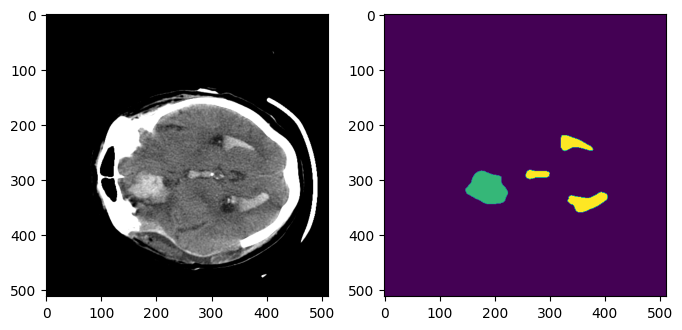

In [167]:
visualize(data)

In [179]:
# 添加channel维度
transform = transforms.EnsureChannelFirstd(keys=["image", "label"])
add_data = transform(data)
print_info(add_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


In [11]:
# 数据保存
transform = transforms.SaveImaged(keys=["image", "label"], output_dir="output", output_ext=".nii.gz", separate_folder=False)
aug_data = transform(data)
print_info(aug_data)

2025-05-15 19:46:15,453 INFO image_writer.py:197 - writing: output\ID_c9d6fdc6_ID_7f09be285d_trans.nii.gz
2025-05-15 19:46:16,273 INFO image_writer.py:197 - writing: output\ID_c9d6fdc6_ID_7f09be285d-ich_pred_trans.nii.gz
image shape: torch.Size([512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


In [51]:
# 将数据pad至指定spatial_size
# - 输入为3D数据，需增强channel维度，即输入[C, H, W, D], spatial_size = [h, w, d]
# - 输入为2D数据，即输入[C, H, W], spatial_size = [h, w]
transform = transforms.SpatialPadd(keys=["image", "label"], spatial_size=[768, 768, 38])

aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 768, 768, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 768, 768, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


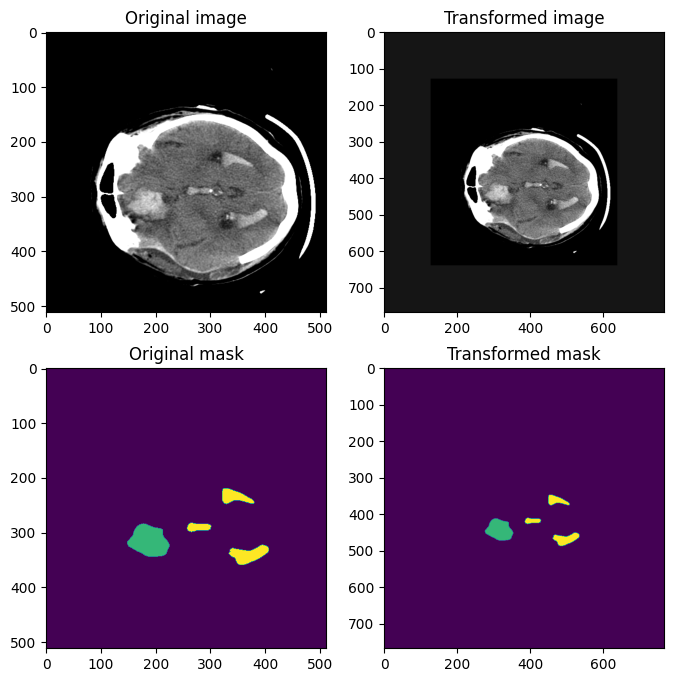

In [49]:
visualize(data, aug_data)

In [52]:
transform = transforms.BorderPadd(keys=["image", "label"], spatial_border=[32, 32, 0])
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 576, 576, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 576, 576, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


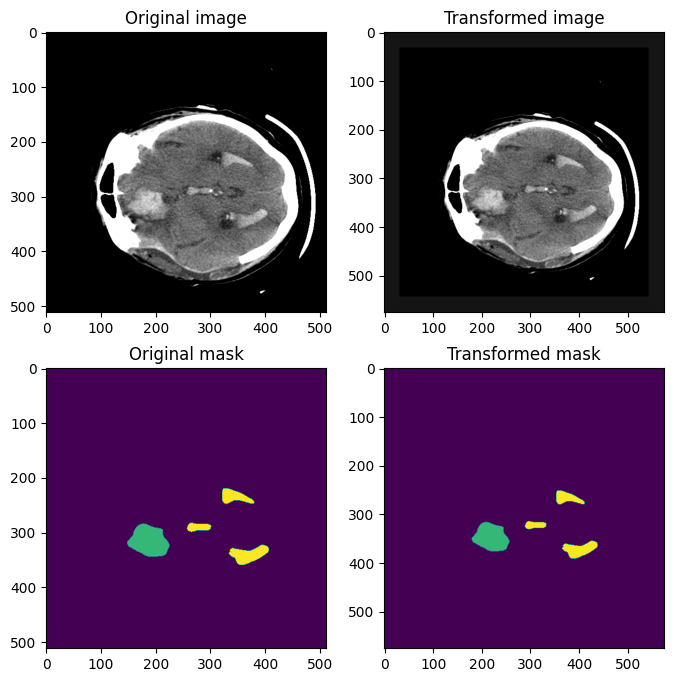

In [53]:
visualize(data, aug_data)

In [54]:
transform = transforms.DivisiblePadd(keys=["image", "label"], k=32)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 512, 512, 64]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 64]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


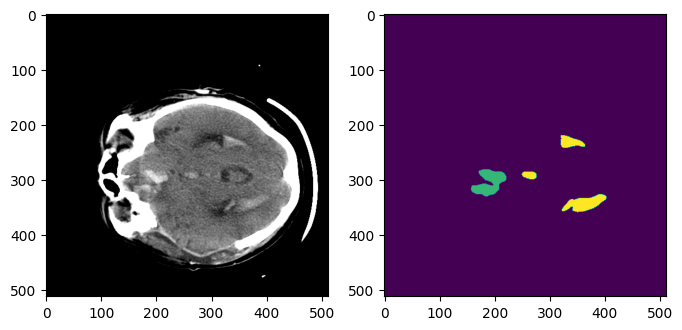

In [55]:
visualize(data, idx=19)

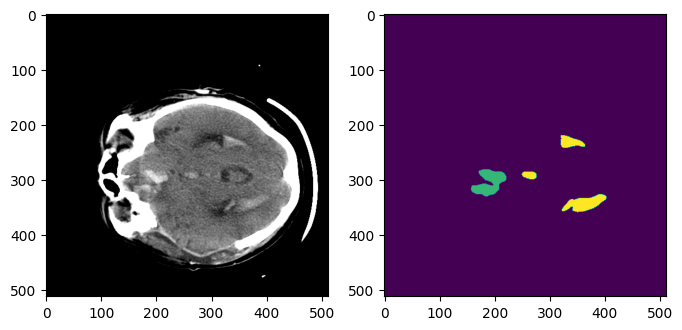

In [56]:
visualize(aug_data, idx=32)

In [62]:
transform = transforms.SpatialCropd(
    keys=["image", "label"],
    roi_center=[256, 256, 19],
    roi_size=[384, 384, 38]
)

transform = transforms.SpatialCropd(
    keys=["image", "label"],
    roi_start=[32, 32, 0],
    roi_end=[484, 484, 38]
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 452, 452, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 452, 452, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


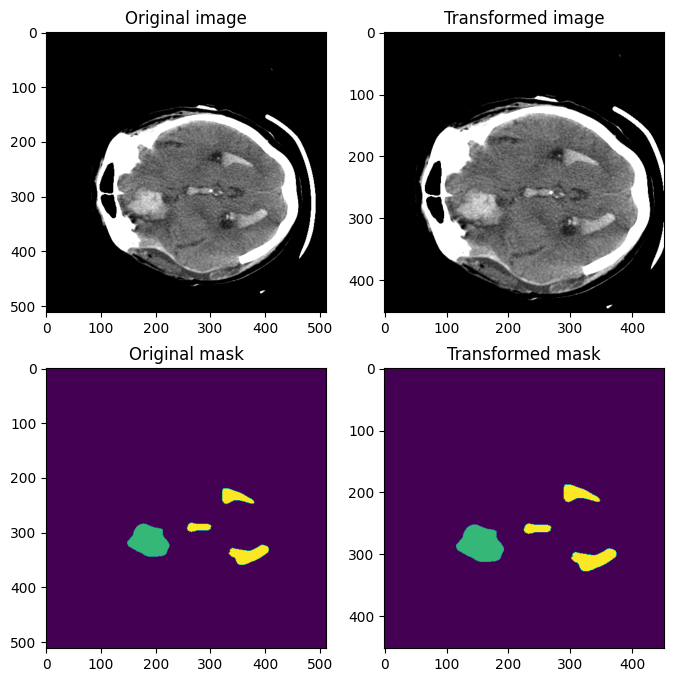

In [63]:
visualize(data, aug_data)

In [66]:
transform = transforms.CenterSpatialCropd(
    keys=["image", "label"],
    roi_size=[384, 384, 38]
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 384, 384, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 384, 384, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


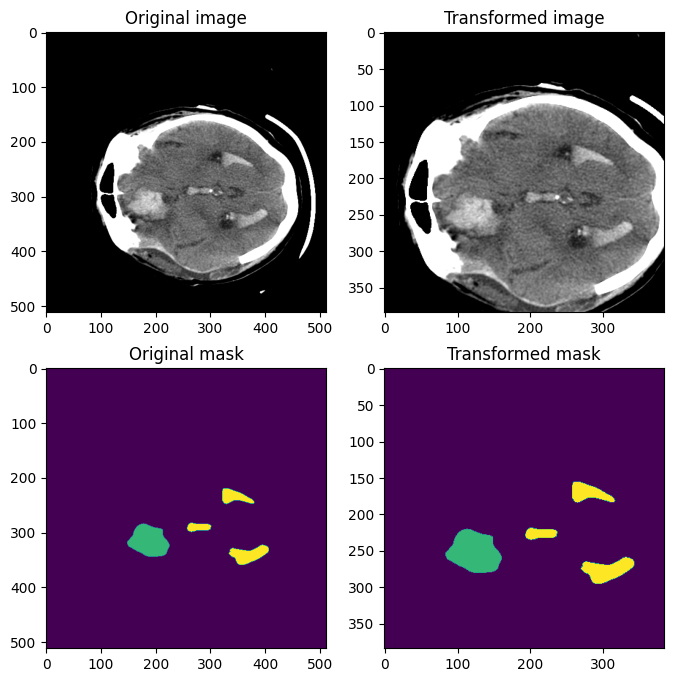

In [67]:
visualize(data, aug_data)

In [68]:
transform = transforms.CenterScaleCropd(
    keys=["image", "label"],
    roi_scale=[0.6, 0.6, 1]
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 308, 308, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 308, 308, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


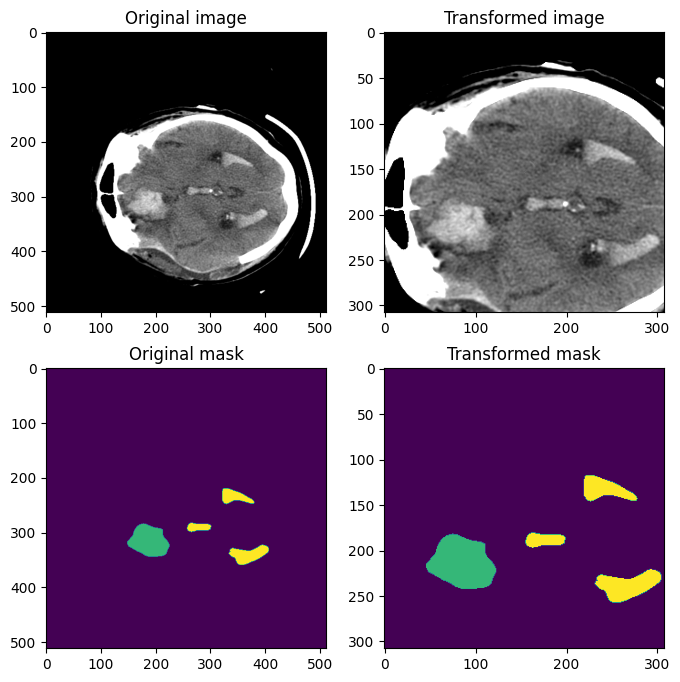

In [69]:
visualize(data, aug_data)

In [71]:
transform = transforms.RandSpatialCropd(
    keys=["image", "label"],
    roi_size=[224, 224, 38],
    max_roi_size=[512, 512, 38],
    random_size=True
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 406, 356, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 406, 356, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


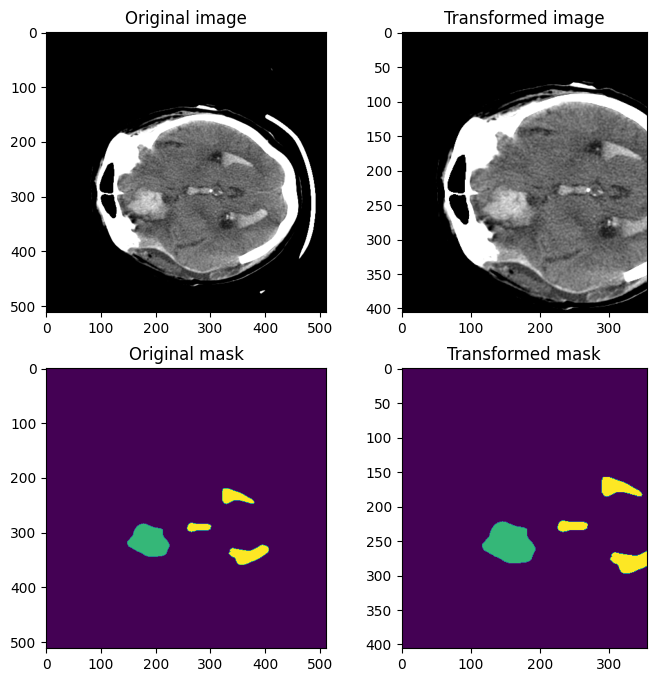

In [72]:
visualize(data, aug_data)

In [76]:
transform = transforms.RandScaleCropd(
    keys=["image", "label"],
    roi_scale=[0.3, 0.3, 1],
    max_roi_scale=[1, 1, 1],
    random_size=True
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 331, 424, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 331, 424, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


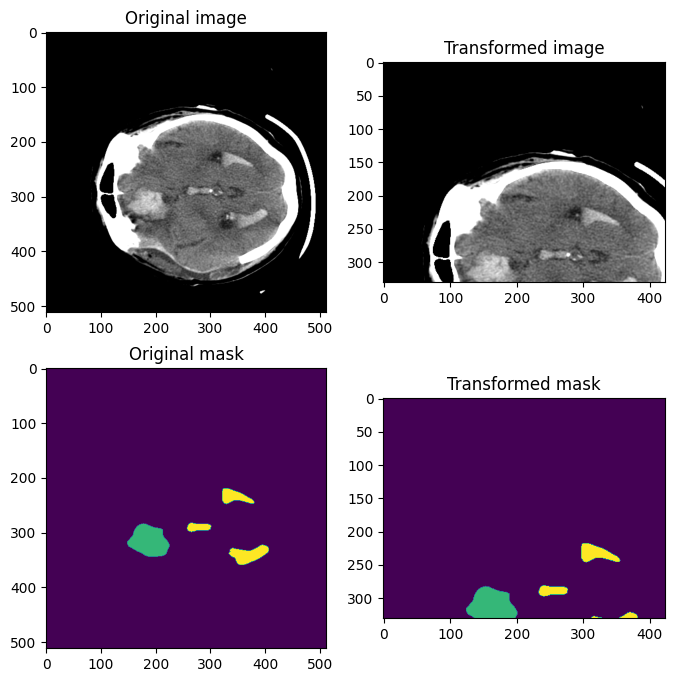

In [77]:
visualize(data, aug_data)

In [78]:
transform = transforms.RandSpatialCropSamplesd(
    keys=["image", "label"],
    roi_size=[224, 224, 38],
    max_roi_size=[512, 512, 38],
    num_samples=4,
    random_size=True
)
aug_datas = transform(add_data)
len(aug_datas)

4

In [80]:
print_info(aug_datas[0])

image shape: torch.Size([1, 266, 439, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 266, 439, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


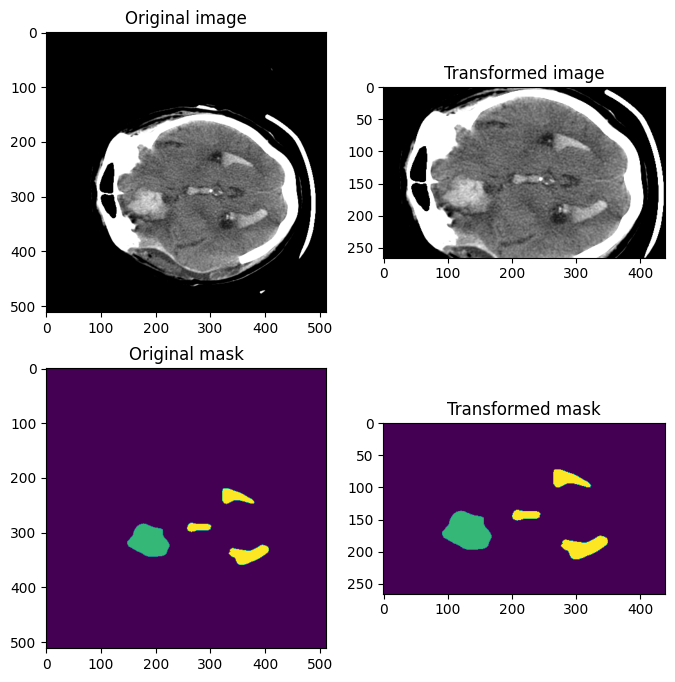

In [81]:
visualize(data, aug_datas[0])

In [92]:
transform = transforms.CropForegroundd(
    keys=["image", "label"],
    source_key="image"
)
aug_data = transform(add_data)
print_info(aug_data)

image shape: torch.Size([1, 418, 456, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 418, 456, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


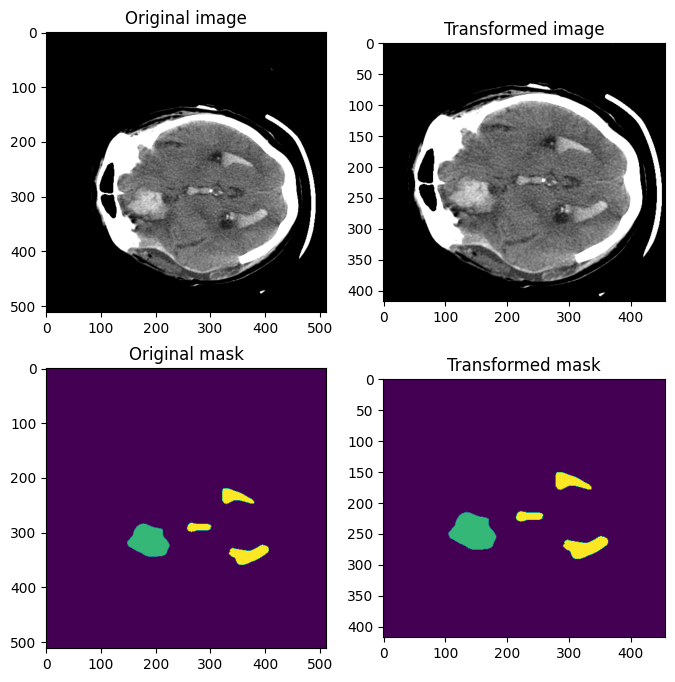

In [89]:
visualize(data, aug_data)

In [116]:
transform = transforms.RandCropByPosNegLabeld(
    keys=["image", "label"],
    label_key="label",
    spatial_size=[224, 224, 38],
    pos=5,
    neg=1,
    num_samples=2,
    image_key="image",
    image_threshold=0
)
aug_datas = transform(add_data)
len(aug_datas)

2

image shape: torch.Size([1, 224, 224, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 224, 224, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


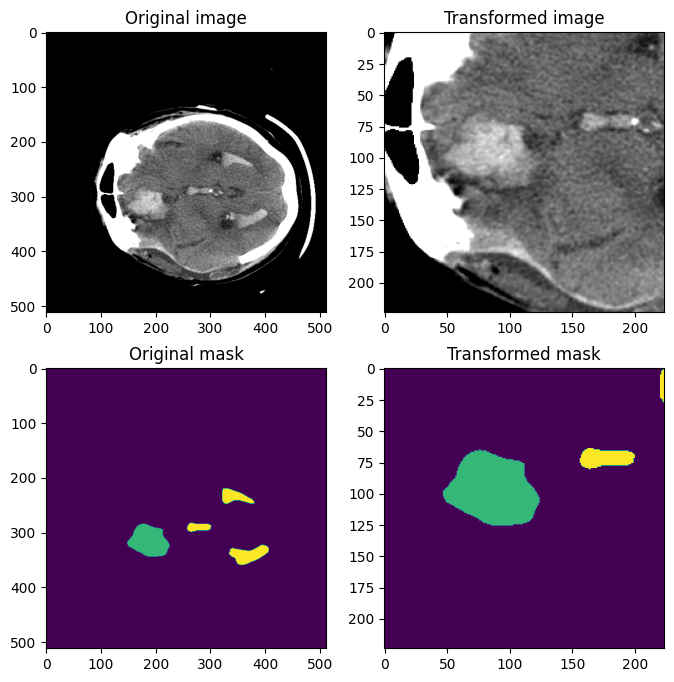

In [117]:
print_info(aug_datas[0])
visualize(data, aug_datas[0])

image shape: torch.Size([1, 224, 224, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 224, 224, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


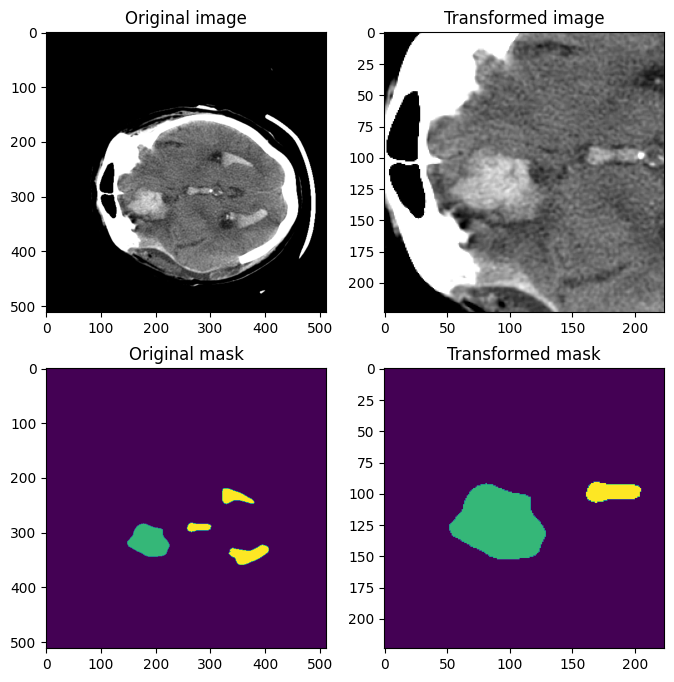

In [118]:
print_info(aug_datas[1])
visualize(data, aug_datas[1])

image shape: torch.Size([1, 448, 448, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 448, 448, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


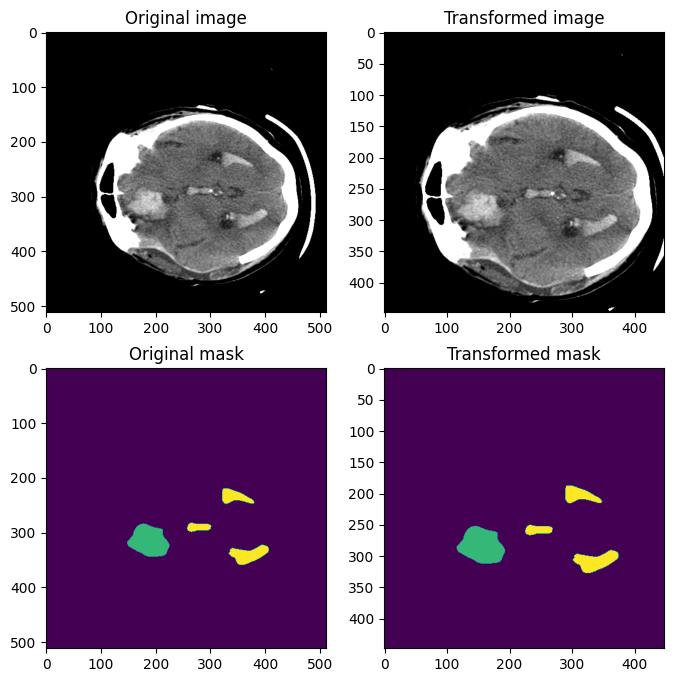

In [121]:
transform = transforms.ResizeWithPadOrCropd(
    keys=["image", "label"],
    spatial_size=[448, 448, 38]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

image shape: torch.Size([1, 768, 768, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 768, 768, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


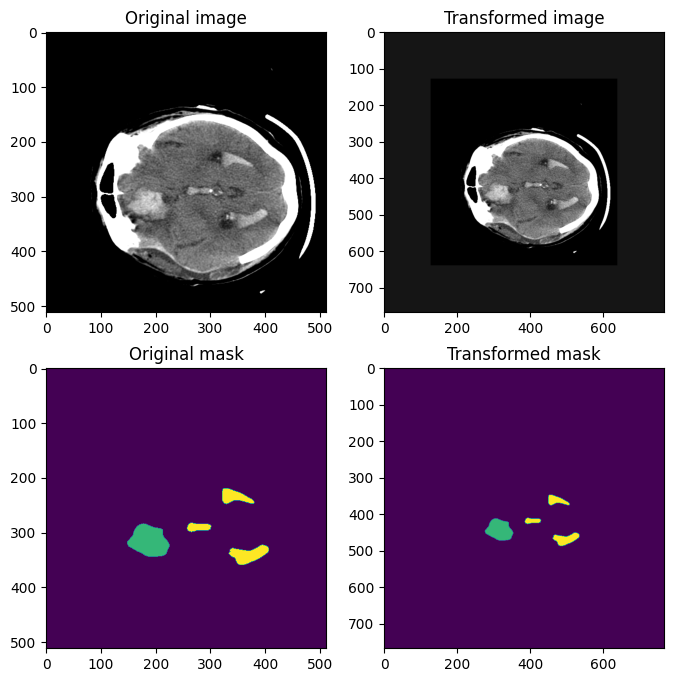

In [122]:
transform = transforms.ResizeWithPadOrCropd(
    keys=["image", "label"],
    spatial_size=[768, 768, 38]
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

在高斯噪声（Gaussian noise）的生成中，`mean` 和 `std`（标准差）起着关键作用。

1. **mean（均值）**：它控制噪声的中心位置，也就是说噪声的期望值。通常，均值设置为0，这样生成的噪声在统计上就不会偏离原始信号。如果均值不为0，噪声会偏向某个方向，可能导致信号失真。

2. **std（标准差）**：它控制噪声的分布范围或强度。标准差越大，噪声的波动范围越广，噪声的影响就越强；标准差越小，噪声更集中，影响较小。通过调整标准差，可以控制噪声的强度，进而控制信号的失真程度。

总结来说，`mean` 决定噪声的偏移位置，`std` 决定噪声的强度。根据具体应用的需求，可以调整这两个参数来实现不同类型的噪声干扰效果。

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


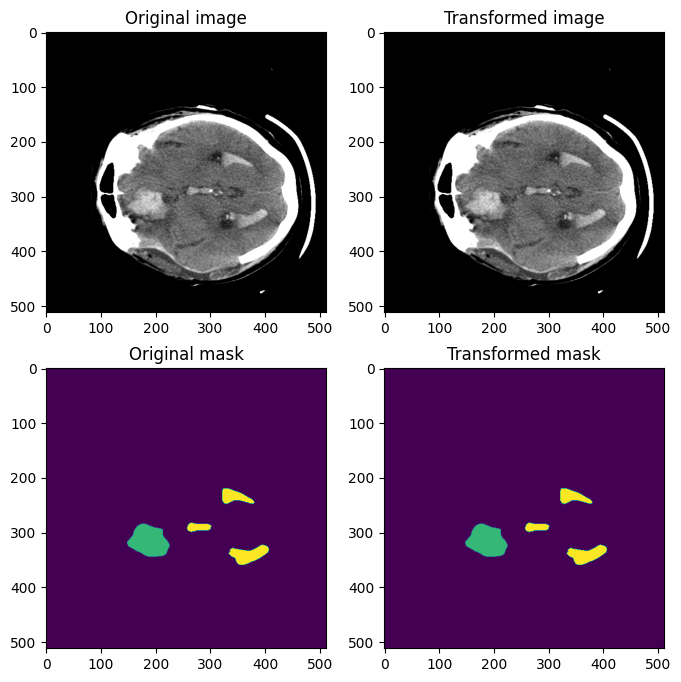

In [148]:
transform = transforms.RandGaussianNoised(
    keys=["image"],
    prob=1,
    mean=0,
    std=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

在信号处理和图像处理领域，RandRicianNoise（瑞利噪声）是一种常见的噪声类型，用于模拟信号中的随机噪声。这种噪声的特点是噪声值服从瑞利分布。瑞利噪声广泛应用于无线通信、医学影像（如MRI）和其他需要模拟噪声的领域。

在生成瑞利噪声时，通常会使用两个参数来描述噪声的统计特性：

1. **mean（均值）**：这是噪声的期望值，表示噪声的平均水平。在瑞利噪声中，均值通常指的是噪声信号的幅度的平均值。
   
2. **std（标准差）**：这是衡量噪声波动程度的指标，表示噪声的分散程度。标准差越大，噪声的变化越剧烈，影响信号的程度也就越大。

具体来说，均值和标准差的作用如下：

- **均值**：影响瑞利噪声的幅度。如果均值增大，噪声的幅度会变大，信号的强度也会增加。
  
- **标准差**：控制噪声的强度和变化范围。标准差越大，噪声的变化越显著，导致更强的干扰。

在实际应用中，调整这些参数可以帮助模拟不同的噪声环境，从而更好地测试和优化信号处理算法或设备性能。

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


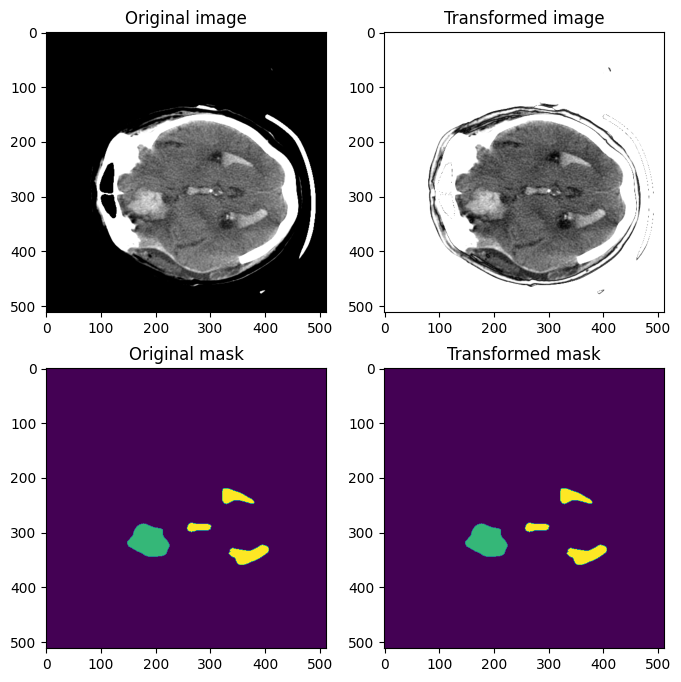

In [151]:
transform = transforms.RandRicianNoised(
    keys=["image"],
    prob=1,
    mean=0,
    std=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

图像处理中，**Shift Intensity（强度偏移）** 是一种简单的图像操作，通常用于调整图像像素的亮度或对比度。它的基本原理是对图像中的每个像素值进行一个常数的加减运算，从而改变图像的整体亮度。

### Shift Intensity 的工作原理：
1. **像素值调整**：在图像处理过程中，每个像素的颜色通常由RGB（红绿蓝）值组成，或者由灰度值（单通道）表示。通过对每个像素的值进行加上或减去一个常数（称为“偏移量”），可以使得整个图像变得更亮或更暗。
   
2. **数学表达式**：
   - 对于灰度图像，设定每个像素的灰度值为 \( I(x, y) \)，偏移量为 \( \Delta \)，则调整后的像素值为：
     \[
     I'(x, y) = I(x, y) + \Delta
     \]
     其中 \( \Delta \) 是常数，正值会使图像变亮，负值则会使图像变暗。

   - 对于彩色图像，RGB 每个通道都可以单独进行强度偏移。例如：
     \[
     R'(x, y) = R(x, y) + \Delta_R
     \]
     \[
     G'(x, y) = G(x, y) + \Delta_G
     \]
     \[
     B'(x, y) = B(x, y) + \Delta_B
     \]
     其中，\( \Delta_R, \Delta_G, \Delta_B \) 分别是红、绿、蓝通道的偏移量。

### 应用：
1. **图像亮度调整**：通过增加一个常数，所有像素的亮度都会增加，通常用来使图像更明亮。
   
2. **图像对比度调整**：虽然 Shift Intensity 主要影响亮度，但它有时也被用来简化对比度的调整，特别是在一些基础的图像处理任务中。

3. **增强或抑制细节**：对图像的某些区域进行强度偏移，可以突出或抑制某些特征，尤其在医学影像或卫星图像处理中经常使用。

### 注意事项：
- **像素值限制**：图像的每个像素值通常有范围限制（例如 0 到 255 对于 8 位图像），因此在进行偏移时，需要确保不会超过这个范围。如果偏移导致像素值超过上限或低于下限，需要进行裁剪（clipping），即将超出范围的像素值设置为最大值或最小值。
  
- **色彩失真**：在彩色图像中，如果偏移量设置不当，可能会导致色彩失真，尤其是在 RGB 分量之间的平衡被打破时。

总结来说，Shift Intensity 是一个简单但有效的图像调整技术，广泛用于图像增强和预处理。

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


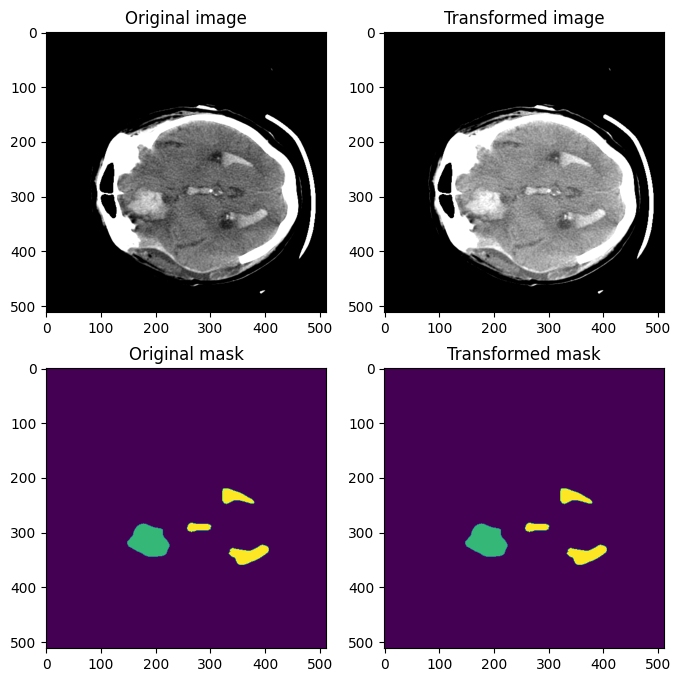

In [180]:
 transform = transforms.RandShiftIntensityd(
     keys=["image"],
     offsets=[10, 20],
     prob=1
 )
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

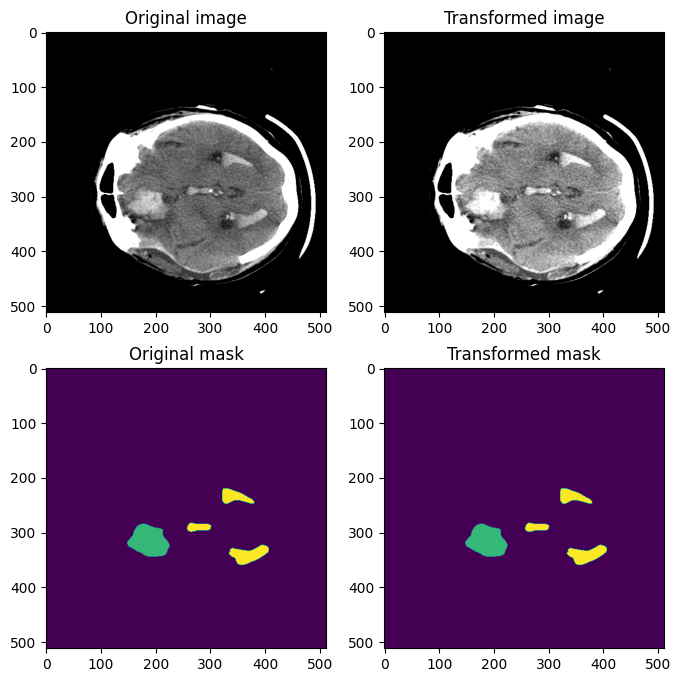

In [197]:
# v = v * (1 + factor)
transform = transforms.RandScaleIntensityd(
    keys="image", 
    factors=(0.3, 0.5), 
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)